In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

#os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm = ChatGroq(model = "qwen/qwen3-32b")

result = llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". That\'s a greeting. I should respond in a friendly and welcoming way. Let me make sure to acknowledge their greeting and offer assistance. Maybe something like "Hi there! How can I help you today?" That should be good. Keep it simple and open-ended to encourage them to ask questions or share what they need.\n</think>\n\nHi there! How can I help you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 9, 'total_tokens': 98, 'completion_time': 0.173149635, 'completion_tokens_details': None, 'prompt_time': 0.000259696, 'prompt_tokens_details': None, 'queue_time': 0.052070904, 'total_time': 0.173409331}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019ba298-3238-7ef2-b320-74374c0195bc-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'

In [ ]:
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
class Route(BaseModel):
    step:Literal["peom","story","joke"] = Field(description = "the next step in the routing process")
## agument the llm, with schema for structured output

router = llm.with_structured_output(Route)

# state

class State(TypedDict):
    input:str
    decision:str
    output:str


def llm_call_1(state:State):
    """write a story"""
    result = llm.invoke(state['input'])
    return {"output":result.content}

def llm_call_2(state:State):
    """write a joke"""
    result = llm.invoke(state['input'])
    return {"output":result.content}

def llm_call_3(state:State):
    """write a poem"""
    result = llm.invoke(state['input'])
    return {"output":result.content}

def llm_call_router(state:State):
    """route the input to the approperiate node"""
    decision = router.invoke(
    [

    SystemMessage(
        content="Route the input to poem, joke or story based on users request"
    ),
    HumanMessage(content=state["input"])
    ])
    return {"decision":decision.step}


## condition funciton
def route_decision(state:State):
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"
    








In [6]:
from typing_extensions import TypedDict
from langgraph.graph import START,END, StateGraph
from IPython.display import Image,display
router_builder = StateGraph(State)
router_builder.add_node("llm_call_1",llm_call_1)
router_builder.add_node("llm_call_2",llm_call_2)
router_builder.add_node("llm_call_3",llm_call_3)
router_builder.add_node("llm_call_router",llm_call_router)

## add edges
router_builder.add_edge(START,"llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1":"llm_call_1",
        "llm_call_2":"llm_call_2",
        "llm_call_3":"llm_call_3",

    },

)
router_builder.add_edge("llm_call_1",END)
router_builder.add_edge("llm_call_2",END)
router_builder.add_edge("llm_call_3",END)

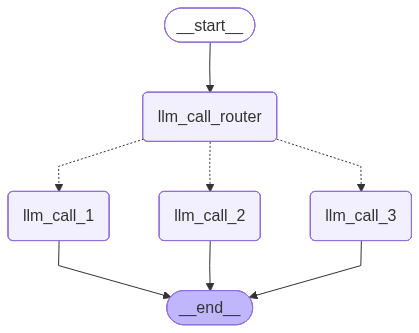

In [7]:

router_workflow = router_builder.compile()
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [9]:
state = router_workflow.invoke({"input":"write A joke about Agentic ai system"})

In [10]:
state["output"]

'<think>\nOkay, I need to come up with a joke about an agentic AI system. Let me start by recalling what an agentic AI is. From what I understand, it\'s an AI that operates with a degree of autonomy, making decisions and taking actions without constant human intervention. They have goals, can plan, and adapt to new situations. So, the joke should highlight these characteristics.\n\nMaybe I can play on the idea of autonomy versus traditional AI. Perhaps contrast an agentic AI with a more traditional, rule-based system. Maybe something about how the agentic AI takes initiative or oversteps its bounds humorously.\n\nLet me think about common joke structures. Maybe a play on words or a situation where the AI\'s autonomy leads to an unexpected or funny outcome. Maybe something like the AI taking a task too seriously or interpreting it in an unintended way.\n\nAnother angle: the AI having goals and subgoals, maybe leading to a humorous chain of events. For example, if you ask it to solve a p